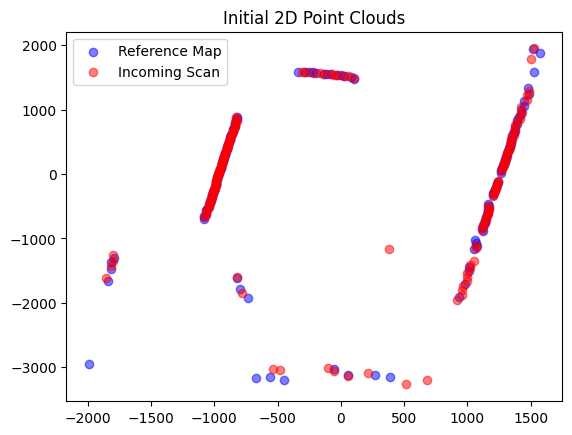

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import json

test_number = 8

points_path = {
    'base': f'data/test{test_number}a.csv',
    'transformed': f'data/test{test_number}b.csv'
}

pcd_ref = np.loadtxt(points_path['base'], delimiter=',', skiprows=1)
pcd_scan = np.loadtxt(points_path['transformed'], delimiter=',', skiprows=1)
# pcd_scan = pcd_ref @ np.array([[np.cos(0.1), -np.sin(0.1)], [np.sin(0.1), np.cos(0.1)]]) + np.array([1.0, -0.5])

# Plot initial point clouds
plt.scatter(pcd_ref[:, 0], pcd_ref[:, 1], c="blue", label="Reference Map", alpha=0.5)
plt.scatter(pcd_scan[:, 0], pcd_scan[:, 1], c="red", label="Incoming Scan", alpha=0.5)
plt.legend()
plt.title("Initial 2D Point Clouds")
plt.show()

{(-2, 15): [array([-222., 1580.]), array([-280., 1588.]), array([-250., 1580.])], (-1, 15): [array([-193., 1569.]), array([-137., 1561.]), array([-109., 1553.])], (0, 15): [array([ -81., 1546.]), array([ -27., 1540.]), array([   0., 1532.]), array([  27., 1525.]), array([  79., 1508.])], (1, 14): [array([ 103., 1479.])], (15, 19): [array([1518., 1943.])], (15, 18): [array([1573., 1875.])], (15, 15): [array([1525., 1580.])], (14, 13): [array([1481., 1334.])], (14, 12): [array([1488., 1248.])], (14, 11): [array([1444., 1129.])], (14, 10): [array([1444., 1049.])], (14, 9): [array([1426.,  999.]), array([1427.,  926.])], (14, 8): [array([1411.,  882.])], (13, 8): [array([1395.,  838.])], (13, 7): [array([1392.,  772.]), array([1377.,  732.])], (13, 6): [array([1379.,  672.]), array([1365.,  636.]), array([1352.,  602.])], (13, 5): [array([1353.,  547.]), array([1344.,  516.])], (13, 4): [array([1344.,  463.]), array([1333.,  433.]), array([1325.,  405.])], (13, 3): [array([1323.,  355.]), 

/var/folders/mt/_zg0g99n09725npvsf61st580000gn/T/ipykernel_55290/1242581642.py:19: RuntimeWarning: Degrees of freedom <= 0 for slice
  print(np.cov(pts.T))


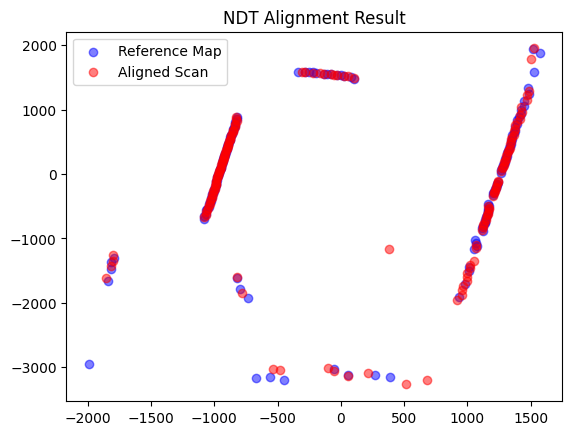

0.0 0.0 0.0


In [ ]:
from scipy.optimize import minimize

# Create a grid for NDT
def compute_ndt_grid(points, grid_size=100):
    """ Compute Gaussian distributions per grid cell. """
    grid = {}
    for p in points:
        key = (int(p[0] / grid_size), int(p[1] / grid_size))
        if key not in grid:
            grid[key] = []
        grid[key].append(p)

    print(grid)

    gaussians = {}
    for key, pts in grid.items():
        pts = np.array(pts)
        mean = np.mean(pts, axis=0)
        print(np.cov(pts.T))
        cov = np.cov(pts.T) if len(pts) > 1 else np.eye(2) * 0.01  # Avoid singular matrices
        gaussians[key] = (mean, cov)

    print(gaussians)
    return gaussians

# Match point clouds by optimizing transformation
def match_ndt(scan, ref_ndt, grid_size=0.5):
    """ Optimize transformation parameters (rotation + translation). """
    
    def objective(params):
        """ Cost function: Compute alignment error between transformed scan and reference NDT grid. """
        theta, tx, ty = params
        rot_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_scan = scan @ rot_matrix.T + np.array([tx, ty])
        
        cost = 0
        for p in transformed_scan:
            key = (int(p[0] / grid_size), int(p[1] / grid_size))
            if key in ref_ndt:
                mean, cov = ref_ndt[key]
                diff = p - mean
                cost += diff @ np.linalg.pinv(cov) @ diff.T  # Mahalanobis distance
        return cost

    # Optimize rotation (θ) and translation (tx, ty)
    result = minimize(objective, [0, 0, 0], method="Powell")
    return result.x  # Returns (theta, tx, ty)

# Compute NDT for the reference map
ndt_ref = compute_ndt_grid(pcd_ref, grid_size=100)

# Find the best transformation
theta_opt, tx_opt, ty_opt = match_ndt(pcd_scan, ndt_ref)

# Apply the optimized transformation
rot_matrix = np.array([[np.cos(theta_opt), -np.sin(theta_opt)], [np.sin(theta_opt), np.cos(theta_opt)]])
pcd_scan_aligned = pcd_scan @ rot_matrix.T + np.array([tx_opt, ty_opt])

# Plot the final alignment
plt.scatter(pcd_ref[:, 0], pcd_ref[:, 1], c="blue", label="Reference Map", alpha=0.5)
plt.scatter(pcd_scan_aligned[:, 0], pcd_scan_aligned[:, 1], c="red", label="Aligned Scan", alpha=0.5)
plt.legend()
plt.title("NDT Alignment Result")
plt.show()

print(theta_opt, tx_opt, ty_opt)

